In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Start by reading processed data and separating it to features and target. Then we check dimensions to be sure.

In [3]:
dataset = pd.read_csv('finished_processed.csv')
print(dataset.keys())
print(dataset.shape)
dataset.drop(['backers_count', 'usd_pledged'], axis=1, inplace=True)
target = dataset['state']
features = dataset.drop(['state'], axis=1)
features.shape

Index(['backers_count', 'category', 'country', 'creator', 'currency', 'goal',
       'staff_pick', 'state', 'usd_pledged', 'location', 'blurb_length',
       'duration'],
      dtype='object')
(164399, 12)


(164399, 9)

In [4]:
print(dataset['state'].value_counts(normalize=True))
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
print(X_train.shape)

1    0.555691
0    0.444309
Name: state, dtype: float64
(123299, 9)


Try default settings for random forest classifier with 100 estimators.

In [5]:
rf = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

Check scores for classifier

In [6]:
predicted = rf.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - rf.oob_score_)
importances = [(features.keys()[i], rf.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.762530413625
0.242921678197
[('category', 0.24130480194378823), ('country', 0.013575672081016456), ('creator', 0.15902330531483128), ('currency', 0.012581457093289481), ('goal', 0.1817612428848091), ('staff_pick', 0.073018820785504895), ('location', 0.14273771505637622), ('blurb_length', 0.095292880534396149), ('duration', 0.080704104305988358)]


Check confusion matrix for classifier

(41100,)


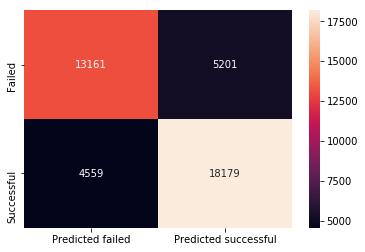

In [7]:
from sklearn.metrics import confusion_matrix

print(y_test.shape)
cfmtx = confusion_matrix(y_test, predicted)
sns.heatmap(cfmtx, annot=True, fmt='g', yticklabels=['Failed', 'Successful'], 
            xticklabels=['Predicted failed', 'Predicted successful'])

Optimize metaparameters with randomized search. We could also use grid search, but it takes more time and performance is not significantly better than randomized search.

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

rf = RandomForestClassifier(n_estimators=100)
# We want to have bootstrap=True for oob_error
param_dist = {"n_estimators": [10, 30, 50, 100],
              "max_depth": [3, None],
              "max_features": [0.8, "sqrt", None],
              "min_samples_split": sp_randint(2, 15),
              "min_samples_leaf": sp_randint(1, 15),
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "oob_score": [True],
              "n_jobs": [-1],
              "random_state": [1]}
rsearch = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, n_jobs=-1, random_state=1)
rsearch.fit(X_train, y_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [10, 30, 50, 100], 'max_depth': [3, None], 'max_features': [0.8, 'sqrt', None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020300C70CC0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020300C70E10>, 'bootstrap': [True], 'criterion': ['gini', 'entropy'], 'oob_score': [True], 'n_jobs': [-1], 'random_state': [1]},
          pre_d

In [8]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(rsearch.cv_results_)
print(rsearch.best_score_)
print(rsearch.best_estimator_)

Model with rank: 1
Mean validation score: 0.7868 (std: 0.0010)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 13, 'min_samples_split': 14, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 1}

Model with rank: 2
Mean validation score: 0.7867 (std: 0.0007)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 1}

Model with rank: 3
Mean validation score: 0.7861 (std: 0.0002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 1}

0.786778481577
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=N

Select the best estimator to be the one used.

In [8]:
#best = rsearch.best_estimator_
best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=14,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)
best.fit(X_train, y_train)
predicted = best.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - best.oob_score_)
importances = [(features.keys()[i], best.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.793090024331
0.209985482445
[('category', 0.45814502433421384), ('country', 0.0095227359709740989), ('creator', 0.069703325143855119), ('currency', 0.013754640963044788), ('goal', 0.1856175094359824), ('staff_pick', 0.10215003733928889), ('location', 0.069493105060796687), ('blurb_length', 0.041619679216535685), ('duration', 0.049993942535308679)]


Drop two of the least significant values and see how it effects performance.

In [10]:
features.drop(['country', 'currency'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
best.fit(X_train, y_train)
predicted = best.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - best.oob_score_)
importances = [(features.keys()[i], best.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.794647201946
0.207893008054
[('category', 0.47808356053245205), ('creator', 0.070891421366851601), ('goal', 0.18670266525553264), ('staff_pick', 0.10080647361138334), ('location', 0.071546549717216468), ('blurb_length', 0.041706393146034443), ('duration', 0.050262936370529449)]


(41100,)


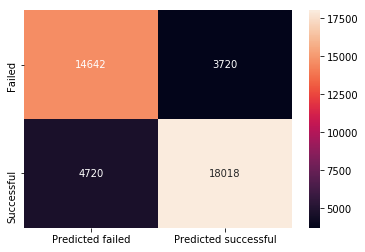

In [11]:
print(y_test.shape)
cfmtx = confusion_matrix(y_test, predicted)
sns.heatmap(cfmtx, annot=True, fmt='g', yticklabels=['Failed', 'Successful'], 
            xticklabels=['Predicted failed', 'Predicted successful'])

Seems that classifier predicts most of our test data correctly, and has a bit more false negatives than false positives.

Finally save our classifier so that we can use it again.

In [11]:
best.fit(features, target)
from sklearn.externals import joblib

joblib.dump(best, 'model.pkl') 


['model.pkl']